In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.impute import SimpleImputer




In [ ]:
base_dir = os.getcwd()
data_dir = os.path.join(base_dir, '../..', 'data')
filepath = os.path.join(data_dir, 'cleaned/final_batters_df.csv')

batters = pd.read_csv(filepath)
batters['won_mvp'] = batters['won_mvp'].astype('category')
batters['won_gold_glove'] = batters['won_gold_glove'].astype('category')
batters['won_cy_young'] = batters['won_cy_young'].astype('category')
batters['position'] = batters['position'].astype('category')
batters['won_silver_slugger'] = batters['won_silver_slugger'].astype('category')
batters['all_star'] = batters['all_star'].astype('category')
batters["free_agent_salary_log"] = np.log1p(batters["free_agent_salary"])

In [6]:
batters_clean = batters.dropna(subset=["free_agent_salary"])
X = batters_clean.drop(columns=["row_id", "playerID","year","free_agent_salary",
                          "ZR","position","WP",'all_star',"contract_length",
                          "won_cy_young","won_mvp","won_gold_glove","won_silver_slugger"])
y = batters_clean["free_agent_salary"]
imputer = SimpleImputer(strategy="median")
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train_raw)
X_test_imputed  = imputer.transform(X_test_raw)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled  = scaler.transform(X_test_imputed)

knn = KNeighborsRegressor()
param_grid = {"n_neighbors":[3,5,7,9,11], "weights":["uniform","distance"]}
grid = GridSearchCV(knn, param_grid, cv=5, scoring="neg_mean_squared_error")
grid.fit(X_train_scaled, y_train)

y_pred = grid.predict(X_test_scaled)

In [7]:
print("Best KNN params:", grid.best_params_)

Best KNN params: {'n_neighbors': 3, 'weights': 'distance'}


In [8]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.5f}")
print(f"Test R^2: {r2:.5f}")

Test MSE: 8262682535554.62305
Test R^2: 0.67970


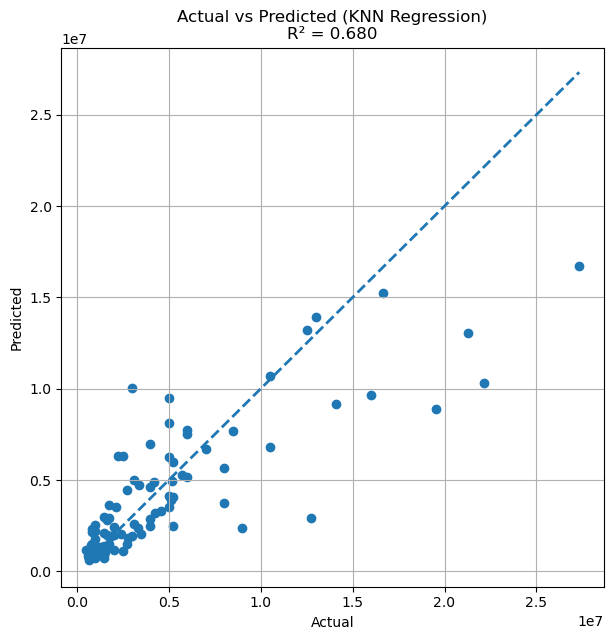

In [9]:
plt.figure(figsize=(7, 7))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', linewidth=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title(f"Actual vs Predicted (KNN Regression)\nR² = {r2:.3f}")
plt.grid(True)
plt.show()

Our test r^squared of 0.68 indicates that our model does a pretty good job of predicting free agent salaries, explaining almost 70% of the variation. Our model MSE demonstrates that on average, our model misclassifies salaries by about $2.8 million dollars. Considering the magnitude of some contracts, this seems reasonable. Looking at our predicted vs average graph, it seems that our model does a decent job of predicting salaries on the low end of the salary spectrum, but seems to overestimate salaries at the upper end. Our best K being 5 indicates that our data that is somewhat general, but still sensative to local changes.